# Домашнее задание по обработке текстов

## Предсказание цены акции по экономическим новостям

Входные данные:
* Новости о компании "Газпром", начиная с 2010 года
* Стоимость акций компании "Газпром" на ММВБ, начиная с 2010 года
    * цена открытия (Open)
    * цена закрытия (ClosingPrice)
    * максимальная цена за день (DailyHigh)
    * минимальная цена за день (DailyLow) 
    * объем бумаг (VolumePcs)


In [2]:
import pandas as pd
df = pd.read_csv('texts.csv')
df.head()

,date,text
0,09.11.2017,Компания рассчитывает на решение по газовому с...
1,08.11.2017,"Как и предполагал “Ъ”, «Газпром», воспользова..."
2,01.11.2017,Новая редакция американских санкций ставит по...
3,30.10.2017,"Как стало известно “Ъ”, известный на рынке ри..."
4,23.10.2017,"НОВАТЭК, который через пять лет собирается за..."


In [21]:
pr_all = pd.read_csv('gazprom_prices.csv', sep=';')
pr_all.head(5)

,Date,Open,ClosingPrice,DailyHigh,DailyLow,VolumePcs
0,08.12.2017,"133,43000","132,60000","133,90000","132,00000",16037970
1,07.12.2017,"133,70000","133,02000","133,87000","132,81000",18198430
2,06.12.2017,"133,33000","134,00000","134,29000","132,91000",14641730
3,05.12.2017,"133,48000","133,65000","133,99000","132,78000",12684800
4,04.12.2017,"133,01000","133,77000","134,00000","131,93000",17818980


In [10]:
pr_all.head()

,Date,Open,ClosingPrice,DailyHigh,DailyLow,VolumePcs
0,08.12.2017,"133,43000","132,60000","133,90000","132,00000",16037970
1,07.12.2017,"133,70000","133,02000","133,87000","132,81000",18198430
2,06.12.2017,"133,33000","134,00000","134,29000","132,91000",14641730
3,05.12.2017,"133,48000","133,65000","133,99000","132,78000",12684800
4,04.12.2017,"133,01000","133,77000","134,00000","131,93000",17818980


### Часть 1. Вводная

Проведите предобработку текстов: если считаете нужным, выполните токенизацию, приведение к нижнему регистру, лемматизацию и/или стемминг. Ответьте на следующие вопросы:
* Есть ли корреляция между средней длинной текста за день и ценой закрытия?
* Есть ли корреляция между количеством упоминаний Алексея Миллера  и ценой закрытия? Учтите разные варианты написания имени.
* Упоминаний какого газопровода в статьях больше: 
    * "северный поток"
    * "турецкий поток"?
* О каких санкциях пишут в статьях?

In [6]:
import re
from nltk.corpus import stopwords
from pymystem3 import Mystem

regex = re.compile("[А-Яа-я-]+")
mystopwords = stopwords.words('russian')
m = Mystem()

def words_only(text, regex=regex):
    return " ".join(regex.findall(text))

def  remove_stopwords(text, mystopwords = mystopwords):
    try:
        return " ".join([token for token in text.split() if not token in mystopwords])
    except:
        return ""
    
def lemmatize(text, mystem=m):
    try:
        return "".join(m.lemmatize(text)).strip()  
    except:
        return " "

df.text = df.text.str.lower()
df.text = df.text.apply(words_only)
df.text = df.text.apply(remove_stopwords)   
df.text = df.text.apply(lemmatize)
df.head(10)

,date,text
0,09.11.2017,компания рассчитывать решение газовый спор укр...
1,08.11.2017,предполагать ъ газпром воспользоваться жалоба ...
2,01.11.2017,новый редакция американский санкция ставить уг...
3,30.10.2017,становиться известно ъ известный рынок риск-ме...
4,23.10.2017,новатэк который пять год собираться запускать ...
5,20.10.2017,российский прокатчик второй год приходиться ра...
6,13.10.2017,газпром подписывать контракт словения поставка...
7,05.10.2017,газпром нефть пробуривать первый скважина аяшс...
8,04.10.2017,спутниковый оператор нтв-плюс последний время ...
9,29.09.2017,становиться известно ъ конкурент начинать разб...


In [38]:
from pandas import Series

#Делаем бинарную фичу isIncr - возросла ли цена
pr_all.insert(1, 'isIncr', Series(pr_all.ClosingPrice > pr_all.Open, index=pr_all.index)) 
pr_all["isIncr"] = pr_all.isIncr.replace({True: 1, False:0})
#Убираем все лишние 
pr_all.drop(["Open", "DailyHigh", "DailyLow", "VolumePcs"], axis=1, inplace=True)
pr_all = pr_all.rename(index=str, columns={"Date": "date"})
pr_all.head()

,date,isIncr,ClosingPrice
0,08.12.2017,0,"132,60000"
1,07.12.2017,0,"133,02000"
2,06.12.2017,1,"134,00000"
3,05.12.2017,1,"133,65000"
4,04.12.2017,1,"133,77000"


Проверим даты на уникальность

In [40]:
if (len(df.date.unique()) == len(df.date)):
    print(1)
else:
    print(0)

1


In [43]:
if (len(pr_all.date.unique()) == len(pr_all.date)):
    print(1)
else:
    print(0)

1


Скопируем датафреймы чтобы не испортить 

In [44]:
t1 = df.copy()
t2 = pr_all.copy()

Соединим датафреймы по дате

In [45]:
t1 = t1.merge(t2, left_on='date', right_on='date', how='outer')
t1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2032 entries, 0 to 2031
Data columns (total 4 columns):
date            2032 non-null object
text            1203 non-null object
isIncr          1988 non-null float64
ClosingPrice    1988 non-null object
dtypes: float64(1), object(3)
memory usage: 79.4+ KB


Выкидываем строки с NaN

In [46]:
t1 = t1.dropna()
t1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1159 entries, 0 to 1201
Data columns (total 4 columns):
date            1159 non-null object
text            1159 non-null object
isIncr          1159 non-null float64
ClosingPrice    1159 non-null object
dtypes: float64(1), object(3)
memory usage: 45.3+ KB


In [47]:
t1.head()

,date,text,isIncr,ClosingPrice
0,09.11.2017,компания рассчитывать решение газовый спор укр...,0.0,"131,50000"
1,08.11.2017,предполагать ъ газпром воспользоваться жалоба ...,1.0,"132,30000"
2,01.11.2017,новый редакция американский санкция ставить уг...,1.0,"126,50000"
3,30.10.2017,становиться известно ъ известный рынок риск-ме...,1.0,"125,98000"
4,23.10.2017,новатэк который пять год собираться запускать ...,0.0,"126,80000"


In [48]:
import warnings
warnings.simplefilter('ignore')

In [369]:
# t1.drop(["miller_count"], axis=1, inplace=True)

In [49]:
tmp = []
for i in range(len(t1['text'])):
    tmp.append(len(t1.text.iloc[i]))

In [50]:
t1.insert(1, 'textLen', Series(tmp, index=t1.index)) 

In [53]:
import numpy as np
t1['ClosingPrice'] = t1['ClosingPrice'].map( lambda closingPrice: np.float32(closingPrice.replace(',', '.')), na_action='ignore')
t1.convert_objects(convert_numeric=True);

In [54]:
t1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1159 entries, 0 to 1201
Data columns (total 5 columns):
date            1159 non-null object
textLen         1159 non-null int64
text            1159 non-null object
isIncr          1159 non-null float64
ClosingPrice    1159 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 54.3+ KB


Тк в тексте у нас леммы слов, уместно искать так, без регулярных выражений

In [55]:
t1['mCount'] = t1.text.map(
    lambda text: text.count('миллер') if text else 0,
    na_action='ignore'
)

Посмотрим как коррелируют полученные значения

Populating the interactive namespace from numpy and matplotlib


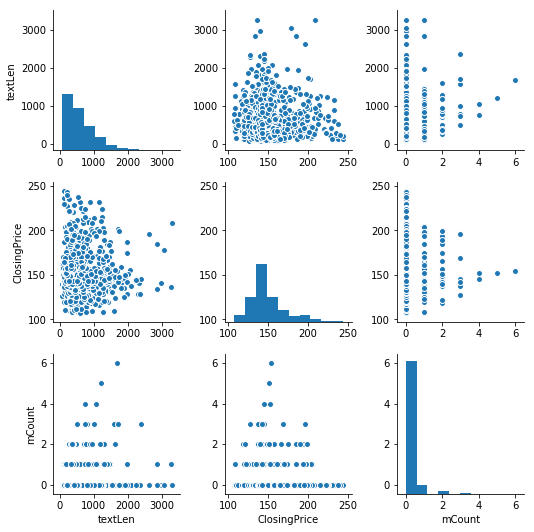

In [59]:
import seaborn as sns
%pylab inline
sns_plot = sns.pairplot(
    t1[['textLen', 'ClosingPrice', 'mCount']]);
sns_plot.savefig('pairplot.png')

Корреляции нет

Тк в тексте у нас леммы слов, уместно искать так, без регулярных выражений

In [60]:
print("Северный поток: {}".format( sum(t1.text.map(lambda text: text.count('северный поток')))))
print("Турецкий поток: {}".format( sum(t1.text.map(lambda text: text.count('турецкий поток')))))

Северный поток: 15
Турецкий поток: 39


С установкой SyntaxNet возникли проблемы

## Часть 2. Классификационная
Вам предстоит решить следующую задачу: по текстам новостей за день определить, вырастет или понизится цена закрытия.
Для этого:
* бинаризуйте признак "цена закрытия":  новый признак ClosingPrice_bin равен 1, если по сравнению со вчера цена не упала, и 0 – в обратном случаея;
* составьте бучающее и тестовое множество: данные до начала 2016 года используются для обучения, данные с 2016 года и позже – для тестирования.

Таким образом, в каждлый момент времени мы знаем: 
* ClosingPrice_bin – бинарый целевой признак
* слова из статей, опубликованных в этот день – объясняющие признаки

В этой части задания вам нужно сделать baseline алгоритм и попытаться его улучшить в следующей части. 

Используйте любой известный вам алгоритм классификации текстов для того, Используйте $tf-idf$ преобразование, сингулярное разложение, нормировку признакого пространства и любые другие техники обработки данных, которые вы считаете нужным. Используйте accuracy и F-measure для оценки качества классификации. Покажите, как  $tf-idf$ преобразование или сингулярное разложение или любая другая использованная вами техника влияет на качество классификации.
Если у выбранного вами алгоритма есть гиперпараметры (например, $\alpha$ в преобразовании Лапласа для метода наивного Байеса), покажите, как изменение гиперпараметра влияет на качество классификации.

In [61]:
t_save = t1.copy()
t_save.head()

,date,textLen,text,isIncr,ClosingPrice,mCount
0,09.11.2017,327,компания рассчитывать решение газовый спор укр...,0.0,131.500000,0
1,08.11.2017,463,предполагать ъ газпром воспользоваться жалоба ...,1.0,132.300003,0
2,01.11.2017,645,новый редакция американский санкция ставить уг...,1.0,126.500000,0
3,30.10.2017,343,становиться известно ъ известный рынок риск-ме...,1.0,125.980003,0
4,23.10.2017,1064,новатэк который пять год собираться запускать ...,0.0,126.800003,0


Не удалось найти никаких существенных признаков влияющих на рост цен. Уберём лишние фичи и разобьём датафрейм на тестовое и тренировочное множества

In [63]:
t1.drop(["ClosingPrice"], axis=1, inplace=True)
t1.drop(["textLen"], axis=1, inplace=True)
t1.drop(["mCount"], axis=1, inplace=True)

In [64]:
date_before = pd.to_datetime('20160101', format='%Y%m%d')
# t1['isIncr'] = 
t1['date'] =  pd.to_datetime(t1['date'], format='%d.%m.%Y')

t1.info()
X_train = t1[t1['date'] < date_before]
X_test = t1[t1['date'] >= date_before]
y_train = X_train.isIncr
y_test = X_test.isIncr
X_train.drop(["isIncr"], axis=1, inplace=True)
X_test.drop(["isIncr"], axis=1, inplace=True)

X_train.shape[0], y_train.shape[0], X_test.shape[0], y_test.shape[0]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1159 entries, 0 to 1201
Data columns (total 3 columns):
date      1159 non-null datetime64[ns]
text      1159 non-null object
isIncr    1159 non-null float64
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 76.2+ KB


(901, 901, 258, 258)

In [65]:
y_train.head()

267    1.0
268    0.0
269    1.0
270    1.0
271    1.0
Name: isIncr, dtype: float64

In [66]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
random_state = 456

# Мультиномиальный наивный Байес (sklearn)

С tf-idf

In [274]:
count_vect = CountVectorizer(ngram_range=(1, 2))
X_train_counts = count_vect.fit_transform(X_train.text)
X_train_counts.shape

(901, 47014)

In [269]:
clf  = Pipeline([
      ('tfidf', TfidfTransformer(smooth_idf=True, sublinear_tf=True, use_idf=True)),
    ('clf', MultinomialNB()),
])

clf.fit(X_train_counts, y_train)

Pipeline(memory=None,
     steps=[('tfidf', TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=True, use_idf=True)), ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [270]:
clf = MultinomialNB().fit(X_train_counts, y_train)

In [271]:
from sklearn.metrics import *
X_test_counts = count_vect.transform(X_test.text)
predicted = clf.predict(X_test_counts)

In [272]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, predicted)

0.48837209302325579

In [273]:
f1_score(y_test, predicted)

0.42105263157894735

Без tf-idf

In [305]:
clf  = Pipeline([
    
    ('clf', MultinomialNB())
])

clf.fit(X_train_counts, y_train)

Pipeline(memory=None,
     steps=[('tfidf', TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=True, use_idf=True)), ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [256]:
X_test_counts = count_vect.transform(X_test.text)
predicted = clf.predict(X_test_counts)

In [257]:
accuracy_score(y_test, predicted)

0.4689922480620155

In [309]:
f1_score(y_test, predicted)

0.39175257731958768

Для мультиномиального наивного Байеса лучший результат оказлся при параметрах:
    CountVectorizer(ngram_range=(1, 2))
    и использованием   $tf-idf$  преобразования.
    Но результат предсказания очень низок.

# Логистическая регрессия или метод максимальной энтропии (sklearn)

In [301]:
count_vect =  CountVectorizer(ngram_range=(1, 1))
X_train_counts = count_vect.fit_transform(X_train.text)
X_test_counts = count_vect.transform(X_test.text)

In [302]:
clf2  = Pipeline([
    ('clf', LogisticRegression())
])

clf2.fit(X_train_counts, y_train)

# clf2 = LogisticRegression().fit(X_train_counts, y_train)
predicted = clf2.predict(X_test_counts)

In [303]:
accuracy_score(y_test, predicted)

0.52325581395348841

In [304]:
f1_score(y_test, predicted)

0.47210300429184548

In [306]:
clf2  = Pipeline([
    ('tfidf', TfidfTransformer(smooth_idf=True, sublinear_tf=True, use_idf=True)),
    ('clf', LogisticRegression())
])

clf2.fit(X_train_counts, y_train)

# clf2 = LogisticRegression().fit(X_train_counts, y_train)
predicted = clf2.predict(X_test_counts)

In [307]:
accuracy_score(y_test, predicted)

0.54263565891472865

In [308]:
f1_score(y_test, predicted)

0.39175257731958768

Для логистической регрессии лучший результат оказался при параметрах:
    CountVectorizer(ngram_range=(1, 1))
    и использованием   $tf-idf$  преобразования.
    Но результат предсказания всё равно очень низок.

## Часть 3. Творческая
Придумайте и попытайтесь сделать еще что-нибудь, чтобы улучшить качество классификации. 
Направления развития:
* Морфологический признаки: 
    * использовать в качестве признаков только существительные или только именованные сущности;
* Модели скрытых тем:
    * использовать в качестве признаков скрытые темы;
    * использовать в качестве признаков динамические скрытые темы 
    пример тут: (https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/dtm_example.ipynb)
* Синтаксические признаки:
    * использовать SOV-тройки в качестве признаков
    * кластеризовать SOV-тройки по эмбеддингам глаголов (обученные word2vec модели можно скачать отсюда: (http://rusvectores.org/ru/models/) и использовать только центроиды кластеров в качестве признаков
* что-нибудь еще     